## MICCAI SCM Baseline

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-01-26 13:09:48.041769: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 13:09:49.554098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-26 13:09:51.243095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [4]:
# overall imports
import importlib
import data

from sim.sim import Simulation
from sim.sim_utils import bytes2human, print_system_usage

# data load
import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_shared_matrices,
    process_cv_splits,  
    expanded_inner_folds_combined_plus_indices
)

import models
import models.metrics
from models.metrics import *

In [5]:
print_system_usage()
total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 53.8%
RAM Usage: 12.9%
Available RAM: 328.4G
Total RAM: 377.1G
52.4G


## Specify connectome and transcriptome

Full brain HCP Enigma

In [60]:
hemisphere = 'both'
PCA = True

HCP_enigma_structural_count, HCP_enigma_labels, HCP_enigma_lh_indices, HCP_enigma_rh_indices = load_connectome(measure='SC', omit_subcortical=False, include_labels=True, diag=0, hemisphere=hemisphere)
HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False, hemisphere=hemisphere)
HCP_coords = load_coords(parcellation='S100', omit_subcortical=False, hemisphere=hemisphere)
HCP_coords_left = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='left')
HCP_coords_right = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='right')
AHBAS100_transcriptome = load_transcriptome(parcellation='S100', omit_subcortical=False, hemisphere=hemisphere, run_PCA=PCA)

Number of components for 95% variance PCA: 34


Full brain HCP1200 and UKBB

In [48]:
hemisphere = 'left' # single hemisphere run is tractable within 2 minutes for closed form solution
PCA = True

HCP1200_structural_count, HCP1200_labels, HCP1200_lh_indices, HCP1200_rh_indices = load_connectome(measure='SC', parcellation='S400', omit_subcortical=False, include_labels=True)
HCP1200_functional_conn = load_connectome(measure='FC', parcellation='S400', omit_subcortical=False)
HCP1200_coords = load_coords(parcellation='S400', omit_subcortical=False)
AHBAS400_transcriptome = load_transcriptome(parcellation='S400', omit_subcortical=False, run_PCA=PCA)

# Find rows that are all NaN - there are 66 regions that are unsampled, and 9 cerebellar regions that are not assigned to hemispheres
nan_rows = np.isnan(AHBAS400_transcriptome).all(axis=1)
nan_row_indices = np.where(nan_rows)[0]
print(f"Contains NaN values: {np.isnan(AHBAS400_transcriptome).any()}")
print(f"Shape of AHBAS400_transcriptome: {AHBAS400_transcriptome.shape}")

# Get valid indices for left and right hemispheres by excluding NaN rows
valid_left_indices = [i for i in HCP1200_lh_indices if i not in nan_row_indices]
valid_right_indices = [i for i in HCP1200_rh_indices if i not in nan_row_indices]

# Combine valid indices from both hemispheres
if hemisphere == 'left':
    valid_indices = valid_left_indices
elif hemisphere == 'right':
    valid_indices = valid_right_indices
else:
    valid_indices = valid_left_indices + valid_right_indices

# Subset transcriptome to only include valid regions
AHBAS400_transcriptome = AHBAS400_transcriptome[valid_indices]
HCP1200_structural_count = HCP1200_structural_count[valid_indices][:, valid_indices]
HCP1200_functional_conn = HCP1200_functional_conn[valid_indices][:, valid_indices]
print(f"Shape of transcriptome after removing NaN regions: {AHBAS400_transcriptome.shape}")
print(f"Contains NaN values: {np.isnan(X).any()}")
print("Shape of HCP1200_structural_count: ", HCP1200_structural_count.shape)
print("Shape of HCP1200_functional_conn: ", HCP1200_functional_conn.shape)

Number of components for 95% variance PCA: 105
Contains NaN values: True
Shape of AHBAS400_transcriptome: (456, 105)
Shape of transcriptome after removing NaN regions: (214, 105)
Contains NaN values: False
Shape of HCP1200_structural_count:  (214, 214)
Shape of HCP1200_functional_conn:  (214, 214)


Assign features and targets

In [61]:
### S100 ###
X = AHBAS100_transcriptome
Y_sc = HCP_enigma_structural_count
Y_fc = HCP_enigma_functional_conn
Y = Y_sc
left_coords = HCP_coords_left
right_coords = HCP_coords_right


# ### S400 ###
# X = AHBAS400_transcriptome
# Y_sc = HCP1200_structural_count
# Y_fc = HCP1200_functional_conn
# Y = Y_sc
# left_coords = HCP1200_coords[valid_left_indices]
# right_coords = HCP1200_coords[valid_right_indices]

# Print shapes of feature and target matrices
print("Feature matrix X shape:", X.shape)
print("Structural connectivity Y_sc shape:", Y_sc.shape) 
print("Functional connectivity Y_fc shape:", Y_fc.shape)
print("Target matrix Y shape:", Y.shape)
print("Left coordinates shape:", left_coords.shape)
print("Right coordinates shape:", right_coords.shape)


Feature matrix X shape: (114, 34)
Structural connectivity Y_sc shape: (114, 114)
Functional connectivity Y_fc shape: (114, 114)
Target matrix Y shape: (114, 114)
Left coordinates shape: (57, 3)
Right coordinates shape: (57, 3)


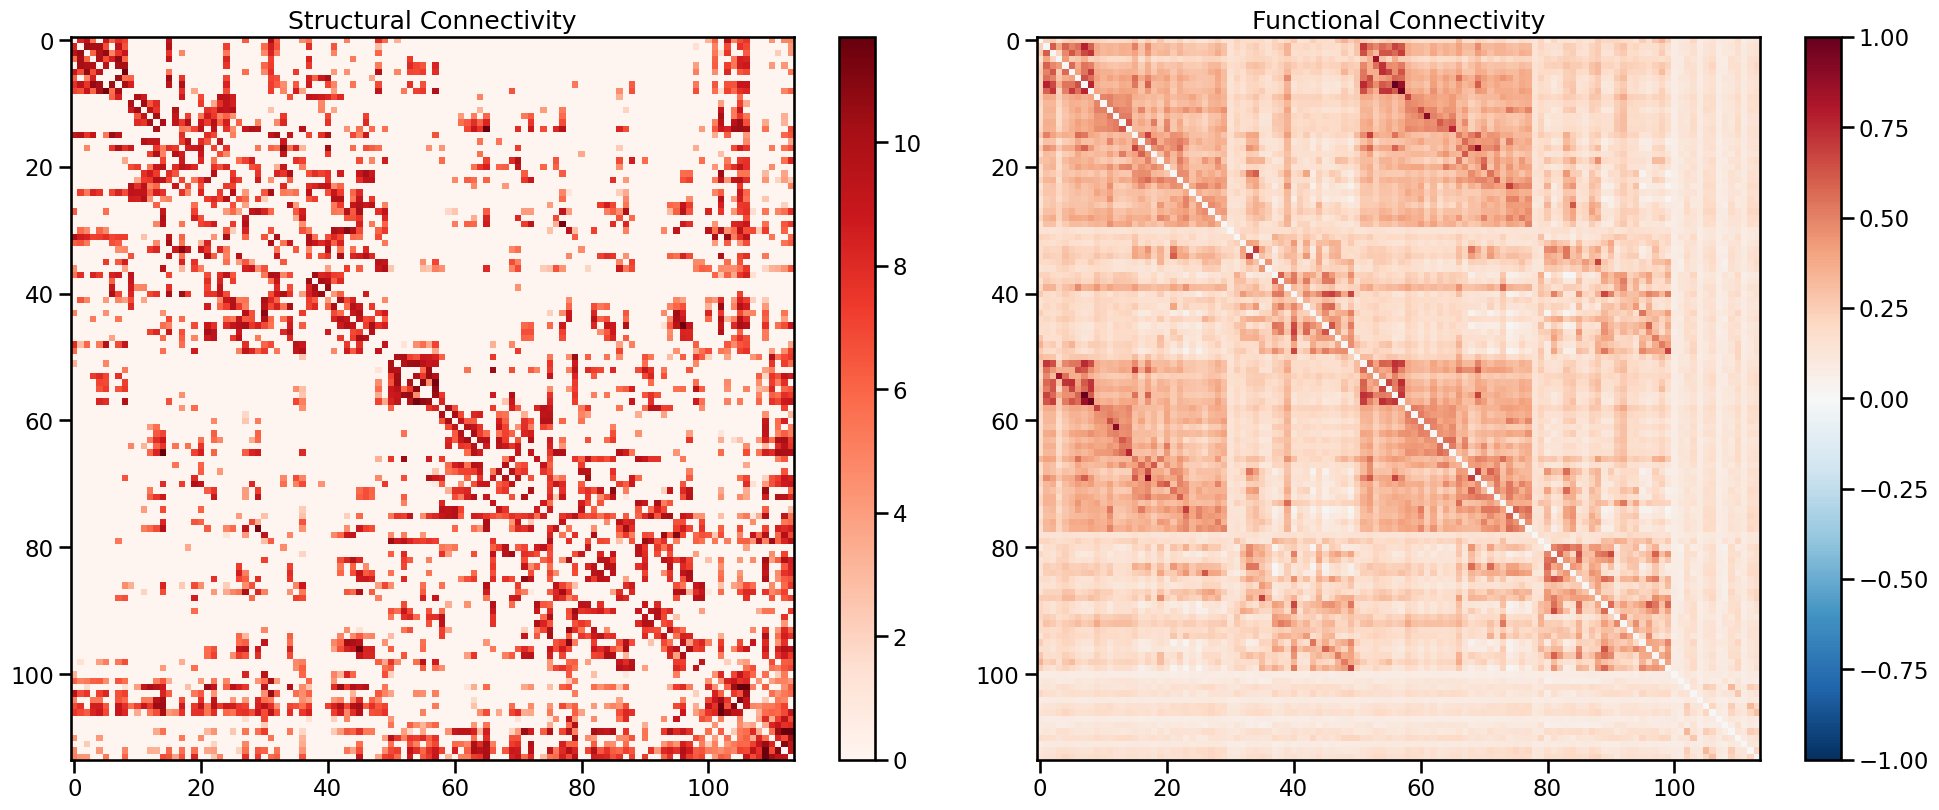

In [62]:
# Visualize structural and functional connectivity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(Y_sc, cmap='Reds')
ax1.set_title('Structural Connectivity')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(Y_fc, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Functional Connectivity') 
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


## Fit SCM model

In [63]:
# Adapted from https://github.com/kpisti/SCM/tree/v1.0. Below implementation is aligned with CM model from full paper. 
def fit_scm(X, Y, alpha=0.25):
    """
    Fit Structural Covariance Model (SCM) to predict connectivity from gene expression.
    
    Args:
        X: Gene expression PCA matrix (regions x gene_PCA_dim)
        Y: Connectivity matrix (regions x regions) 
        alpha: Regularization parameter for ridge regression
        
    Returns:
        O: Estimated rule matrix (gene_PCA_dim x gene_PCA_dim)
        Y_pred: Predicted connectivity matrix (regions x regions)
        objective: Objective function value
    """
    # Compute Kronecker product of X with itself to obtain K matrix
    print(f"X shape: {X.shape}")
    K = np.kron(X, X)
    print(f"K shape after Kronecker: {K.shape}")
    
    # Flatten connectivity matrix Y
    print(f"Y shape before flatten: {Y.shape}")
    Y_flat = Y.flatten()
    print(f"Y_flat shape: {Y_flat.shape}")
    
    # Compute K transpose multiplied by K
    K_transpose_K = np.dot(K.T, K)
    print(f"K_transpose_K shape: {K_transpose_K.shape}")
    
    # Add regularization term
    K_reg = K_transpose_K + alpha * np.identity(K_transpose_K.shape[0])
    print(f"K_reg shape: {K_reg.shape}")
    
    # Compute the pseudo-inverse solution
    K_pseudo_inv = np.linalg.inv(K_reg).dot(K.T)
    print(f"K_pseudo_inv shape: {K_pseudo_inv.shape}")
    
    # Estimate the rule matrix in vectorized form
    O_flat = K_pseudo_inv.dot(Y_flat)
    print(f"O_flat shape: {O_flat.shape}")
    
    # Compute residuals and objective
    residuals = Y_flat - np.dot(K, O_flat)
    print(f"Residuals shape: {residuals.shape}")
    residual_norm = np.linalg.norm(residuals)
    
    K_proj = np.dot(K, K_pseudo_inv)
    print(f"K_proj shape: {K_proj.shape}")
    tau = np.trace(np.identity(K_proj.shape[0]) - K_proj)
    print(f"tau: {tau}")
    
    objective = (residual_norm ** 2) / (tau ** 2)
    print(f"objective: {objective}")

    # Reshape O to original dimensions
    O = O_flat.reshape(X.shape[1], X.shape[1])
    
    # Predict connectivity matrix
    Y_pred = np.dot(X, np.dot(O, X.T))
    
    # Min-max scale Y_pred to [-1,1] range
    return O, Y_pred, objective

# Fit the model
O, Y_pred, objective = fit_scm(X, Y, alpha=0.25)

# Flatten matrices for calculations
y_true = Y.flatten()
y_pred = Y_pred.flatten()

# Calculate Pearson correlation
pearson_r, _ = stats.pearsonr(y_true, y_pred)

# Calculate R-squared
r2 = r2_score(y_true, y_pred)

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)

print("\nSCM model metrics:")
print(f"Pearson r: {pearson_r:.3f}")
print(f"R-squared: {r2:.3f}") 
print(f"MSE: {mse:.3f}")


X shape: (114, 34)
K shape after Kronecker: (12996, 1156)
Y shape before flatten: (114, 114)
Y_flat shape: (12996,)
K_transpose_K shape: (1156, 1156)
K_reg shape: (1156, 1156)
K_pseudo_inv shape: (1156, 12996)
O_flat shape: (1156,)
Residuals shape: (12996,)
K_proj shape: (12996, 12996)
tau: 11840.028287167774
objective: 0.0009260828159370611

SCM model metrics:
Pearson r: 0.574
R-squared: 0.018
MSE: 9.990


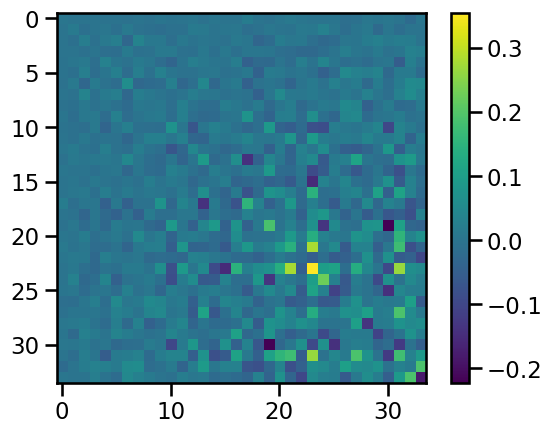

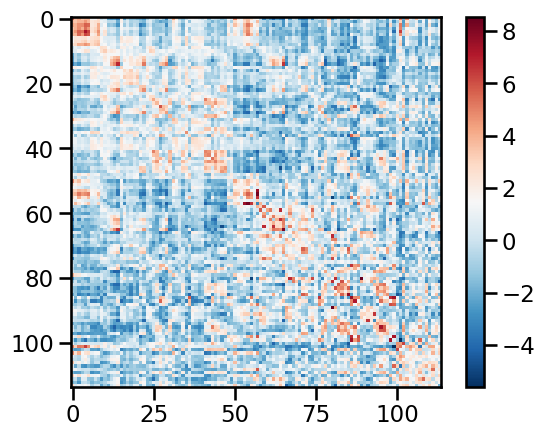

In [64]:
plt.imshow(O)
plt.colorbar()
plt.show()

im = plt.imshow(Y_pred, cmap='RdBu_r')
plt.colorbar(im)
plt.show()

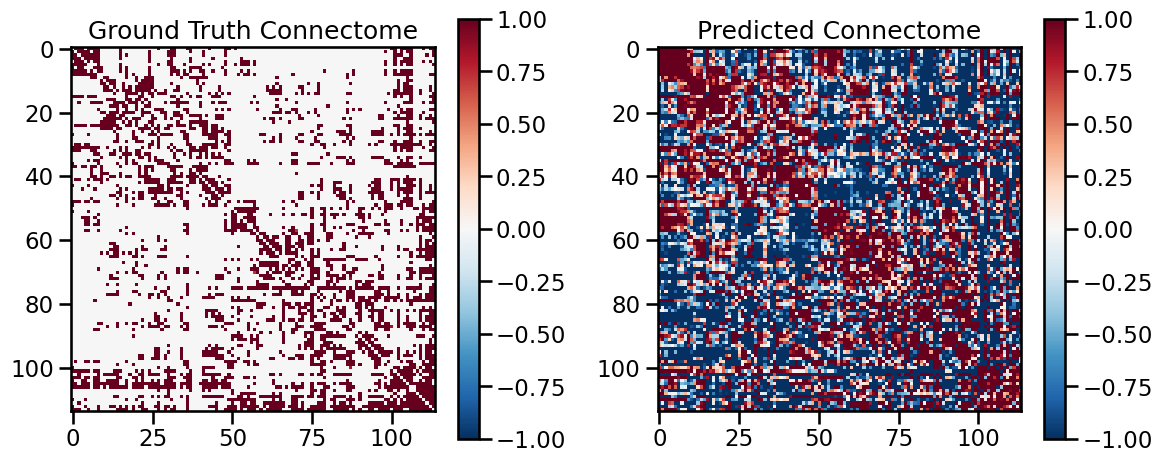

In [65]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Ground Truth Connectome')
plt.colorbar(im1, ax=ax1)

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Predicted Connectome')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


X shape: (114, 34)
K shape after Kronecker: (12996, 1156)
Y shape before flatten: (114, 114)
Y_flat shape: (12996,)
K_transpose_K shape: (1156, 1156)
K_reg shape: (1156, 1156)
K_pseudo_inv shape: (1156, 12996)
O_flat shape: (1156,)
Residuals shape: (12996,)
K_proj shape: (12996, 12996)
tau: 11840.028287167774
objective: 0.0009260828159370611
permutation 100 of 100
hemisphere:  both
rotated_ids shape: (114, 100)
X shape: (114, 34)
K shape after Kronecker: (12996, 1156)
Y shape before flatten: (114, 114)
Y_flat shape: (12996,)
K_transpose_K shape: (1156, 1156)
K_reg shape: (1156, 1156)
K_pseudo_inv shape: (1156, 12996)
O_flat shape: (1156,)
Residuals shape: (12996,)
K_proj shape: (12996, 12996)
tau: 11840.028287167774
objective: 0.0011203062043843328
X shape: (114, 34)
K shape after Kronecker: (12996, 1156)
Y shape before flatten: (114, 114)
Y_flat shape: (12996,)
K_transpose_K shape: (1156, 1156)
K_reg shape: (1156, 1156)
K_pseudo_inv shape: (1156, 12996)
O_flat shape: (1156,)
Residuals

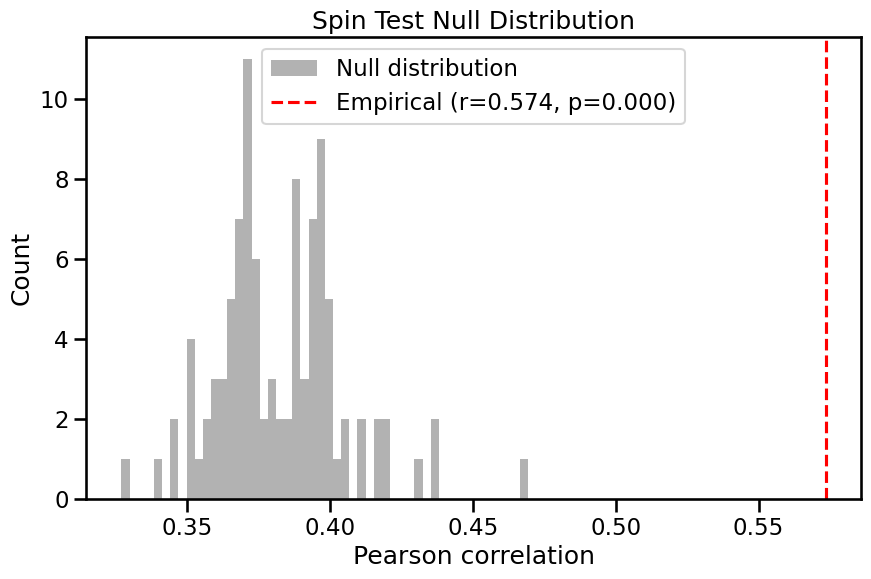

In [66]:
def run_spin_test(X, Y_true, left_coords, right_coords, hemisphere, n_perms=100, shuffle_target=True):
    """
    Run spin test permutation analysis for SCM model
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input transcriptome data
    Y_true : array-like of shape (n_samples, n_samples) 
        Input connectome data
    left_coords : array-like
        Left hemisphere coordinates
    right_coords : array-like  
        Right hemisphere coordinates
    n_perms : int, default=100
        Number of permutations for null distribution
    shuffle_target : bool, default=True
        If True, shuffle connectome (Y). If False, shuffle transcriptome (X)
        
    Returns:
    --------
    empirical_corr : float
        Empirical correlation
    p_value : float
        P-value from permutation test
    null_corrs : array
        Null distribution correlations
    """
    # Calculate empirical correlation
    O, Y_pred, _ = fit_scm(X, Y_true)
    empirical_corr = stats.pearsonr(Y_true.flatten(), Y_pred.flatten())[0]

    # Generate all rotations beforehand
    rotated_ids = rotate_parcellation(left_coords, right_coords, nrot=n_perms)
    rotated_ids = rotated_ids.astype(int)
    print('hemisphere: ', hemisphere)

    
    if hemisphere == 'left':
        rotated_ids = rotated_ids[:len(left_coords)]
    elif hemisphere == 'right':
        rotated_ids = rotated_ids[len(left_coords):]

    print(f"rotated_ids shape: {rotated_ids.shape}")
    # Initialize array to store null correlations
    null_corrs = np.zeros(n_perms)

    # Generate null distribution
    for i in range(n_perms):
        perm_ids = rotated_ids[:, i]
        
        if shuffle_target:
            # Shuffle connectome
            Y_rotated = Y_true[perm_ids][:, perm_ids]
            X_rotated = X
        else:
            # Shuffle transcriptome
            Y_rotated = Y_true
            X_rotated = X[perm_ids]
        
        # Fit SCM on rotated data
        O_null, Y_pred_null, _ = fit_scm(X_rotated, Y_rotated)
        
        # Calculate correlation
        null_corrs[i] = stats.pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = np.mean(null_corrs >= empirical_corr)

    # Plot null distribution
    plt.figure(figsize=(10, 6))
    plt.hist(null_corrs, bins=50, alpha=0.6, color='gray', label='Null distribution')
    plt.axvline(empirical_corr, color='red', linestyle='--', 
                label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    plt.xlabel('Pearson correlation')
    plt.ylabel('Count')
    plt.title('Spin Test Null Distribution')
    plt.legend()
    plt.show()
    
    return empirical_corr, p_value, null_corrs

# Run the spin test
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X,
    Y_true=Y,
    left_coords=left_coords,
    right_coords=right_coords,
    hemisphere=hemisphere,
    n_perms=100,
    shuffle_target=False
)


### Pytorch SCM model

In [68]:
from models.bilinear import BilinearSCM  # using gradient based optimization

X_expanded = expand_X_symmetric(X) # PCA version
Y_expanded = expand_Y_symmetric(Y)
print('X_expanded.shape: ', X_expanded.shape)
print('Y_expanded.shape: ', Y_expanded.shape)

scm_torch_model = BilinearSCM(input_dim=X_expanded.shape[1], learning_rate=0.0003, epochs=100, 
                 batch_size=400, regularization='l2', lambda_reg=0.25, bias=True)

scm_torch_model.fit(X_expanded, Y_expanded)
Y_pred = scm_torch_model.predict(X_expanded)


X_expanded.shape:  (12882, 68)
Y_expanded.shape:  (12882,)
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/100, Train Loss: 101.5265
Epoch 20/100, Train Loss: 37.8163
Epoch 30/100, Train Loss: 20.4172
Epoch 40/100, Train Loss: 14.1997
Epoch 50/100, Train Loss: 11.5679
Epoch 60/100, Train Loss: 10.1533
Epoch 70/100, Train Loss: 9.3702
Epoch 80/100, Train Loss: 8.9146
Epoch 90/100, Train Loss: 8.5546
Epoch 100/100, Train Loss: 8.3982


Bilinear layer weights shape: (1, 34, 34)

Bilinear weights:
[[[ 4.07414371e-03 -1.45058293e-04 -1.05114785e-04 ... -1.78901758e-03
   -1.86703242e-02  4.05029021e-03]
  [-4.77167167e-04  1.52410492e-02 -9.89028066e-03 ... -1.50164533e-02
   -1.63233478e-03  8.44114693e-04]
  [-3.83242441e-04 -9.74019617e-03  2.27147713e-02 ...  1.93794463e-02
    1.80969499e-02  2.87832692e-03]
  ...
  [-1.84261764e-03 -1.46988146e-02  2.30782665e-02 ...  1.14806965e-01
    2.66582724e-02  3.32371593e-02]
  [-2.03571450e-02 -1.63858058e-03  1.91899650e-02 ...  1.82343889e-02
    5.60781993e-02  1.00876316e-01]
  [ 2.97063286e-03  2.58404668e-03  2.56493012e-03 ...  5.28077893e-02
    8.81625116e-02 -5.04741557e-02]]]

Bilinear bias:
[0.74948967]


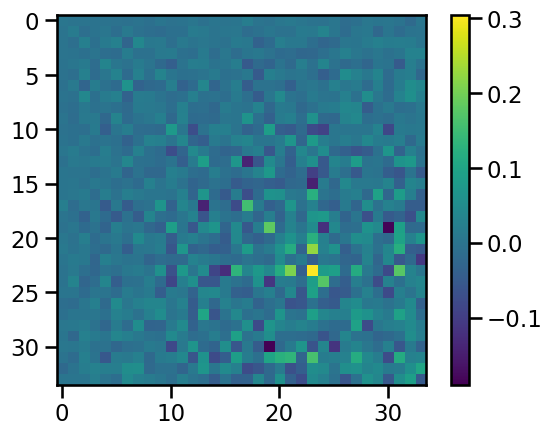

In [69]:
# Get bilinear layer weights
bilinear_weights = scm_torch_model.bilinear.weight.detach().cpu().numpy()
bilinear_bias = scm_torch_model.bilinear.bias.detach().cpu().numpy()

print("Bilinear layer weights shape:", bilinear_weights.shape)
print("\nBilinear weights:")
print(bilinear_weights)
print("\nBilinear bias:")
print(bilinear_bias)

plt.imshow(bilinear_weights.reshape(bilinear_weights.shape[-2], bilinear_weights.shape[-1]))
plt.colorbar()
plt.show()


In [70]:
# Calculate metrics
pearson = stats.pearsonr(Y_expanded, Y_pred)[0]
mse = np.mean((Y_expanded - Y_pred)**2)
r2 = r2_score(Y_expanded, Y_pred)
print(f"Pearson correlation: {pearson:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R2 score: {r2:.3f}")

Y_pred = reconstruct_connectome(Y_pred)

Pearson correlation: 0.587
MSE: 7.871
R2 score: 0.231


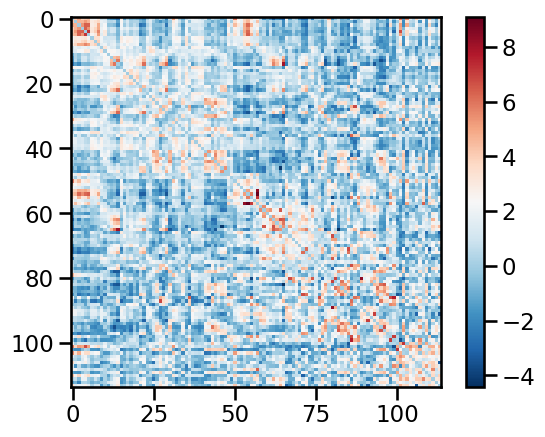

In [71]:
im = plt.imshow(Y_pred, cmap='RdBu_r')
plt.colorbar(im)
plt.show()

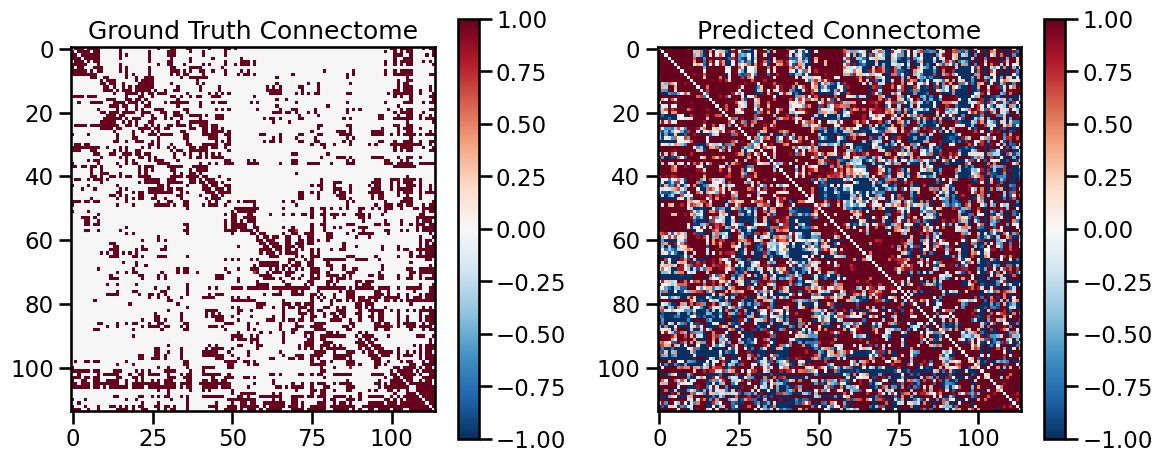

In [72]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Ground Truth Connectome')
plt.colorbar(im1, ax=ax1)

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Predicted Connectome')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()